## Desafio 8 - Previsão das notas de matemática do Enem 2016

*Jéssica Ramos*

In [1]:
# importa as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

### Base de dados

Primeiro vou ler as bases de treino e teste e conhecer suas características.

In [2]:
# treino
treino = pd.read_csv('train.csv')
treino.shape

(13730, 167)

In [3]:
# teste
teste = pd.read_csv('test.csv')
teste.shape

(4576, 47)

A base de treino contém 13.730 observações (75%) e a base de teste 4.576 observações (25%), totalizando 18.306.

A primeira coisa que vamos verificar se há dados ausentes na coluna do *target*.

In [4]:
# quantidade de NaN
treino['NU_NOTA_MT'].isna().sum()

3597

Essas linhas serão removidas da base de treino final.

In [5]:
# remove linhas com NaN no target
treino = treino[treino['NU_NOTA_MT'].notna()]
treino.shape

(10133, 167)

Também é importante destacar que, apesar da base de treino ter 167 colunas, a base de teste tem apenas 47. Vou verificar primeiro as colunas em comum em ambas as bases.

In [6]:
# olha quantas colunas têm em comum
colunas_treino = treino.columns
colunas_teste = teste.columns

colunas_comum = list(set(colunas_teste).intersection(colunas_treino))
len(colunas_comum)

47

Acima podemos ver que todas as colunas no banco de teste também se encontram no banco de treino. Dentre estas, vamos separar as que podemos considerar como *features* do modelo.

In [7]:
# lista de possíveis features
colunas_comum.sort()
colunas_comum

['CO_PROVA_CH',
 'CO_PROVA_CN',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'CO_UF_RESIDENCIA',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_DISCALCULIA',
 'IN_DISLEXIA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'IN_SABATISTA',
 'IN_SURDEZ',
 'IN_TREINEIRO',
 'NU_IDADE',
 'NU_INSCRICAO',
 'NU_NOTA_CH',
 'NU_NOTA_CN',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_LC',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'SG_UF_RESIDENCIA',
 'TP_ANO_CONCLUIU',
 'TP_COR_RACA',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_ENSINO',
 'TP_ESCOLA',
 'TP_LINGUA',
 'TP_NACIONALIDADE',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_LC',
 'TP_SEXO',
 'TP_STATUS_REDACAO',
 'TP_ST_CONCLUSAO']

Consultando o dicionário dos dados vi que as variáveis `CO_PROVA_CH`, `CO_PROVA_CN`, `CO_PROVA_LC` e `CO_PROVA_MT` são identificações de qual tipo de prova o aluno realizou. Portanto, não serão utilizadas como *features*.

Além dessas, a variável `NU_INSCRICAO` também será removida por se tratar do número de inscrição do aluno.

In [8]:
# features
features = colunas_comum.copy()
features.remove('CO_PROVA_CH')
features.remove('CO_PROVA_CN')
features.remove('CO_PROVA_LC')
features.remove('CO_PROVA_MT')
features.remove('NU_INSCRICAO')

len(features)

42

Também serão removidas as variáveis que são indicativos de pedidos de atendimento especializado.

In [9]:
features.remove('IN_BAIXA_VISAO')
features.remove('IN_CEGUEIRA')
features.remove('IN_DISCALCULIA')
features.remove('IN_DISLEXIA')
features.remove('IN_GESTANTE')
features.remove('IN_IDOSO')
features.remove('IN_SABATISTA')
features.remove('IN_SURDEZ')
features.remove('IN_TREINEIRO')

len(features)

33

Agora é necessário verificar se existem dados ausentes nas *features*.

In [10]:
treino[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10133 entries, 0 to 13729
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CO_UF_RESIDENCIA        10133 non-null  int64  
 1   NU_IDADE                10133 non-null  int64  
 2   NU_NOTA_CH              10097 non-null  float64
 3   NU_NOTA_CN              10097 non-null  float64
 4   NU_NOTA_COMP1           10133 non-null  float64
 5   NU_NOTA_COMP2           10133 non-null  float64
 6   NU_NOTA_COMP3           10133 non-null  float64
 7   NU_NOTA_COMP4           10133 non-null  float64
 8   NU_NOTA_COMP5           10133 non-null  float64
 9   NU_NOTA_LC              10133 non-null  float64
 10  NU_NOTA_REDACAO         10133 non-null  float64
 11  Q001                    10133 non-null  object 
 12  Q002                    10133 non-null  object 
 13  Q006                    10133 non-null  object 
 14  Q024                    10133 non-null

As variáveis `Q027`, `TP_DEPENDENCIA_ADM_ESC` e `TP_ENSINO` contém mais da metade dos dados ausentes. Portanto, elas serão removidas da base de fatures.

In [11]:
# remove features com dados ausentes
features.remove('Q027')
features.remove('TP_DEPENDENCIA_ADM_ESC')
features.remove('TP_ENSINO')

len(features)

30

Também será removida a coluna `CO_UF_RESIDENCIA` pois contém a mesma informação de `SG_UF_RESIDENCIA`, porém codificada.

In [12]:
# remove feature "duplicada"
features.remove('CO_UF_RESIDENCIA')

len(features)

29

As variáveis `NU_NOTA_CH` e `NU_NOTA_CN` contém alguns dados ausentes. Como são dados de notas, é razoável assumir que, nesses casos, o candidato não realizou a prova. Portanto a sota será substituída por 0.

In [13]:
# número de NaN em NU_NOTA_CH
treino['NU_NOTA_CH'].isna().sum()

36

In [14]:
# substitui os NaN por 0
treino['NU_NOTA_CH'].fillna(0, inplace = True)

In [15]:
# número de NaN em  NU_NOTA_CN
treino['NU_NOTA_CN'].isna().sum()

36

In [16]:
# substitui os NaN por 0
treino['NU_NOTA_CN'].fillna(0, inplace = True)

É necessário verificar também as colunas com dados ausentes na base de teste.

In [17]:
teste[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4576 entries, 0 to 4575
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NU_IDADE           4576 non-null   int64  
 1   NU_NOTA_CH         3442 non-null   float64
 2   NU_NOTA_CN         3442 non-null   float64
 3   NU_NOTA_COMP1      3377 non-null   float64
 4   NU_NOTA_COMP2      3377 non-null   float64
 5   NU_NOTA_COMP3      3377 non-null   float64
 6   NU_NOTA_COMP4      3377 non-null   float64
 7   NU_NOTA_COMP5      3377 non-null   float64
 8   NU_NOTA_LC         3377 non-null   float64
 9   NU_NOTA_REDACAO    3377 non-null   float64
 10  Q001               4576 non-null   object 
 11  Q002               4576 non-null   object 
 12  Q006               4576 non-null   object 
 13  Q024               4576 non-null   object 
 14  Q025               4576 non-null   object 
 15  Q026               4576 non-null   object 
 16  Q047               4576 

As variáveis `NU_NOTA_CH`, `NU_NOTA_CN`, `NU_NOTA_COMP1`, `NU_NOTA_COMP2`, `NU_NOTA_COMP3`, `NU_NOTA_COMP4`, `NU_NOTA_COMP5`, `NU_NOTA_LC` e `NU_NOTA_REDACAO` também são notas e também serão imputadas com o valor 0.

In [18]:
# subtitui NaN por 0
teste['NU_NOTA_CH'].fillna(0, inplace = True)

In [19]:
# substitui NaN por 0
teste['NU_NOTA_CN'].fillna(0, inplace = True)

As variáveis `NU_NOTA_COMP1`, `NU_NOTA_COMP2`, `NU_NOTA_COMP3`, `NU_NOTA_COMP4`, `NU_NOTA_COMP5`, `NU_NOTA_LC` e `NU_NOTA_REDACAO` também receberão a imputação da média observada na base de treino.

In [20]:
# substitui NaN por 0
teste['NU_NOTA_COMP1'].fillna(0, inplace = True)

In [21]:
# substitui NaN por 0
teste['NU_NOTA_COMP2'].fillna(0, inplace = True)

In [22]:
# substitui NaN por 0
teste['NU_NOTA_COMP3'].fillna(0, inplace = True)

In [23]:
# substitui NaN por 0
teste['NU_NOTA_COMP4'].fillna(0, inplace = True)

In [24]:
# substitui NaN por 0
teste['NU_NOTA_COMP5'].fillna(0, inplace = True)

In [25]:
# substitui NaN por 0
teste['NU_NOTA_LC'].fillna(0, inplace = True)

In [26]:
# substitui NaN por 0
teste['NU_NOTA_REDACAO'].fillna(0, inplace = True)

A variável `TP_STATUS_REDACAO` também contém dados ausentes e a decisão foi de removê-la. Como esse dado só está ausente na base de teste, não seria possível criar uma categoria extra indicando que o dado está ausente, que seria a estratégia utilizada para tratar os dados ausentes.

In [27]:
features.remove('TP_STATUS_REDACAO')

len(features)

28

Também serão removidas as variáveis que indicam a presença do candidato nas demais provas. Essa informação já está, de certa forma, contida na nota final do candidato.

In [28]:
features.remove('TP_PRESENCA_CH')
features.remove('TP_PRESENCA_CN')
features.remove('TP_PRESENCA_LC')

len(features)

25

Após esses ajustes, restaram 25 variáveis completas para serem incluídas no modelo.

In [29]:
# tipo dos dados das features
treino[features].dtypes

NU_IDADE              int64
NU_NOTA_CH          float64
NU_NOTA_CN          float64
NU_NOTA_COMP1       float64
NU_NOTA_COMP2       float64
NU_NOTA_COMP3       float64
NU_NOTA_COMP4       float64
NU_NOTA_COMP5       float64
NU_NOTA_LC          float64
NU_NOTA_REDACAO     float64
Q001                 object
Q002                 object
Q006                 object
Q024                 object
Q025                 object
Q026                 object
Q047                 object
SG_UF_RESIDENCIA     object
TP_ANO_CONCLUIU       int64
TP_COR_RACA           int64
TP_ESCOLA             int64
TP_LINGUA             int64
TP_NACIONALIDADE      int64
TP_SEXO              object
TP_ST_CONCLUSAO       int64
dtype: object

As variáveis `TP_ANO_CONCLUIU`, `TP_COR_RACA`, `TP_NACIONALIDADE` e `TP_ST_CONCLUSAO` são, na verdade, variáveis categóricas que estão codificadas como números inteiros. Dessa forma, é necessário transformar o tipo da coluna para `object`.

In [30]:
# transforma o tipo das colunas
treino['TP_ANO_CONCLUIU'] = treino['TP_ANO_CONCLUIU'].astype('category')
teste['TP_ANO_CONCLUIU'] = teste['TP_ANO_CONCLUIU'].astype('category')

treino['TP_COR_RACA'] = treino['TP_COR_RACA'].astype('category')
teste['TP_COR_RACA'] = teste['TP_COR_RACA'].astype('category')

treino['TP_ESCOLA'] = treino['TP_ESCOLA'].astype('category')
teste['TP_ESCOLA'] = teste['TP_ESCOLA'].astype('category')

treino['TP_NACIONALIDADE'] = treino['TP_NACIONALIDADE'].astype('category')
teste['TP_NACIONALIDADE'] = teste['TP_NACIONALIDADE'].astype('category')

treino['TP_ST_CONCLUSAO'] = treino['TP_ST_CONCLUSAO'].astype('category')
teste['TP_ST_CONCLUSAO'] = teste['TP_ST_CONCLUSAO'].astype('category')

Antes de iniciar o ajuste do modelo, é preciso separar as bases, fazer *one-hot encoding* nos dados categóricos e aplicar o *standard scaler* nos dados numéricos.

In [31]:
# separa o target e as features de treino
x_treino = pd.get_dummies(treino[features])
y_treino = treino['NU_NOTA_MT']

# separa as features de teste e o número de inscrição
x_teste = pd.get_dummies(teste[features])
inscricao_teste = teste['NU_INSCRICAO']

In [32]:
# formato da base de treino após one-hot encoding
x_treino.shape

(10133, 118)

In [33]:
# formato da base de teste após one-hot encoding
x_teste.shape

(4576, 117)

Os dados de teste têm uma variável a menos, pois a categoria '4' não aparece para a variável `TP_ESCOLA`. Portanto, essa coluna será adicionada manualmente.

In [34]:
# diferenças entre as bases de treino e teste
x_treino.columns.difference(x_teste.columns)

Index(['TP_ESCOLA_4'], dtype='object')

In [35]:
# cria a coluna que falta
x_teste['TP_ESCOLA_4'] = 0

In [36]:
x_teste.shape

(4576, 118)

### Modelo Linear

Para ajustar o modelo linear, vou utilizar todas as features que foram separadas nos passos anteriores.

In [37]:
# ajuste do modelo
regressao_linear = LinearRegression()
regressao_linear.fit(x_treino, y_treino)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
# predição nos dados de teste
pred_regressao_linear = regressao_linear.predict(x_teste)

resultado_regressao_linear = pd.DataFrame({'NU_INSCRICAO': inscricao_teste, 'NU_NOTA_MT': pred_regressao_linear})
resultado_regressao_linear

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,454.285343
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,477.723459
2,b38a03232f43b11c9d0788abaf060f7366053b6d,551.027681
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,150.066610
4,715494628a50142ce8cb17191cfe6d0f3cae0934,538.229752
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,460.868548
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,431.958321
4573,655fa6306720ff16e825903b5422a46608a77545,607.097842
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,438.536424


In [39]:
# descritivas das predições
resultado_regressao_linear['NU_NOTA_MT'].describe()

count    4576.000000
mean      394.339582
std       164.196426
min        67.258683
25%       289.821040
50%       451.202264
75%       499.682727
max       761.776356
Name: NU_NOTA_MT, dtype: float64

O ideal seria ter o resultado dos dados de teste para poder calcular medidas de qualidade do modelo que seriam mais reais. Porém, como a base não possui essa informação, serão calculadas as medidas na base de treino.

In [40]:
# predição nos dados de treino
pred_treino_regressao_linear = regressao_linear.predict(x_treino)

# cálculo do R2
r2_score(y_treino, pred_treino_regressao_linear)

0.4327625089858217

Pelo resultado do R² é possível concluir que o modelo não explica grande parte da variabilidade.

In [41]:
# mean squared error
mean_squared_error(y_treino, pred_treino_regressao_linear)

5652.130988159322

In [42]:
# mean absolute error
median_absolute_error(y_treino, pred_treino_regressao_linear)

49.62114188222756

Pelo resultado no MAE, é possível afirmar que o modelo costuma errar em 49 pontos, sejá para cima ou para baixo.

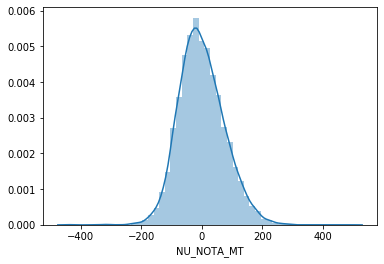

In [43]:
# distribuição dos resíduos
residuos_regressao_linear = y_treino - pred_treino_regressao_linear
sns.distplot(residuos_regressao_linear)

A distribuição dos resíduos se assemelha à distribuição Normal e está centrado em zero.

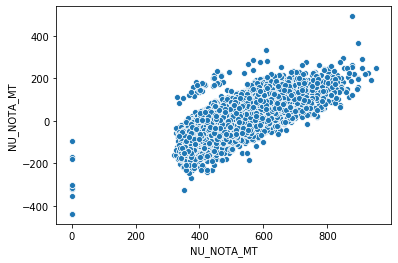

In [44]:
# resíduos versus valor ajustado
sns.scatterplot(x=y_treino, y=residuos_regressao_linear)

Existe padrão na distribuição dos resíduos versus o valor ajustado. Isso é um indicativo de que um modelo linear não é a melhor escolha para esse problema.

### *Gradient Boosting Machine*

Já que o modelo linear não se ajustou bem aos dados, a próxima tentativa será com um algoritmo mais robusto e que não depende de relações lineares: o *Gradient Boosting Machine*.

In [45]:
# ajusta o modelo
gbm = GradientBoostingRegressor(random_state=0)
gbm.fit(x_treino, y_treino)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
# predição nos dados de treino
pred_treino_gbm = gbm.predict(x_treino)

# cálculo do R2
r2_score(y_treino, pred_treino_gbm)

0.5224147515273427

In [47]:
# mean squared error
mean_squared_error(y_treino, pred_treino_gbm)

4758.8081273573725

In [48]:
# mean absolute error
median_absolute_error(y_treino, pred_treino_gbm)

46.02715489333906

Ajustando um GBM com os parâmetros *default* já foi possível obter resultados melhores.

In [49]:
# predição nos dados de teste
pred_gbm = gbm.predict(x_teste)

resultado_gbm = pd.DataFrame({'NU_INSCRICAO': inscricao_teste, 'NU_NOTA_MT': pred_gbm})
resultado_gbm 

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,436.560057
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,472.805043
2,b38a03232f43b11c9d0788abaf060f7366053b6d,576.738523
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,66.133244
4,715494628a50142ce8cb17191cfe6d0f3cae0934,534.015210
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,464.885451
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,456.885875
4573,655fa6306720ff16e825903b5422a46608a77545,680.099369
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,436.758109


In [50]:
# descritivas
resultado_gbm['NU_NOTA_MT'].describe()

count    4576.000000
mean      367.782131
std       207.654917
min       -54.862182
25%        88.670380
50%       446.294192
75%       488.462321
max       840.892817
Name: NU_NOTA_MT, dtype: float64

In [51]:
# salva o arquivo de resultado
resultado_gbm.to_csv('answer.csv')